In [1]:
import torch, os
from sentence_transformers import SentenceTransformer, util
from pandas import read_csv as rcsv, DataFrame as df, melt
from time import time as t
from warnings import filterwarnings as fw; fw("ignore")

from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\Nicholas Dominic\Documents\Semantic Caching\venv_scllm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### UDFs

In [2]:
def symmetric_semantic_search(
    query : str,
    corpus : list,
    corpus_emb : torch.Tensor,
    top_k : int = 5,
    kg_enhanced : bool = False,
    kgraph : list = None,
    kgraph_emb : torch.Tensor = None,
    *args, **kwargs
) -> dict:
    
    start_time = t()
    kg_entity = None
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    
    if kg_enhanced:
        if kgraph is None or kgraph_emb is None:
            raise ValueError("If `kg_enhanced` is True, you must pass both `kgraph` and `kgraph_emb`.")
        else:
            # find the most relevant from knowledge graph
            x = symmetric_semantic_search(query=query, corpus=kgraph, corpus_emb=kgraph_emb, top_k=1)
            kg_entity = list(x["scores"].keys())[0]
            x_emb = embedder.encode(kg_entity, convert_to_tensor=True)
            query_embedding += x_emb
    
    cos_scores = util.cos_sim(query_embedding, corpus_emb)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    
    return { 
        "scores" : {corpus[idx] : score.item() for score, idx in zip(top_results[0], top_results[1])},
        "kg_entity" : kg_entity,
        "query_embedding" : query_embedding,
        "exc_time" : round(t()-start_time, 5)
    }

In [3]:
def get_embeddings(corpus : list, filename : str, *args, **kwargs) -> torch.Tensor:
    savepath_corpus_emb = "results/"
    if [p for p in os.listdir("results") if p.endswith("{}.pt".format(filename))]:
        corpus_embeddings = torch.load(savepath_corpus_emb + "{}.pt".format(filename))
    else:
        corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
        torch.save(corpus_embeddings, "results/{}.pt".format(filename))
    
    return corpus_embeddings

### Main

In [4]:
if __name__ == "__main__":
    # use all-MiniLM-L6-v2 as the embedding model
    embedder = SentenceTransformer("all-MiniLM-L6-v2")

    # prepare corpus
    kg = rcsv("results/knowledge_graph_wiki_v2.csv")
    kg_corpus = [n.source + " " + n.edge + " " + n.target for _, n in kg.iterrows()]

    q_corpus = [
        "Which movie was credited as a social drama feature film?",
        "What movie was released on April?",
        "What was the purpose of filming a movie scene on paper film?",
        "What was the movie that won the Film Institute Award?",
        "Which musical composition by Benjamin Wallfisch was released in 2004?",
        "Which music released by Aditya Music Company was the most popular?",
        "How did the music received positive reviews?",
        "What was the soundtrack released digitally June?",
        "What is the name of the soundtracks composed by Anirudh Ravichander?",
        "Which song was added to the Soundtrack of the United States National Recording Registry?"
    ]

    # get the embedding
    kg_emb = get_embeddings(kg_corpus, "embedding_kgraph")
    q_emb = get_embeddings(q_corpus, "embedding_query")
    
    # alternative user prompts
    alt_user_prompts = [
        "Tell me the social drama movie.",
        "Which movie was published on April?",
        "Is there any specific purpose why a movie scene shot with paper film?",
        "Give me a list of musics that won the Film Institute Award.",
        "Wallfisch released a music in 2004. What is it?",
        "List for me the most popular music by Aditya Music.",
        "Why some movies can received no negative reviews?",
        "Give me the music released in June.",
        "I want to know what are soundtracks created by A. Ravichander.",
        "What are songs registered in the US National Recording?",
        "What are movies registered in the US National Recording?", # test: replace "songs" with "movies"
        "What are sports registered in the US National Recording?", # test: replace "songs" with "sports" (wrong context)
        "songs US National registered Recording in?" # test: scramble words
    ]
    
    # ====================================================================
    # UNCOMMENT THIS SECTION TO RERUN THE RESULT AND SAVE IT TO DATAFRAME
    # ====================================================================
    
    # cache_words = []
    # prec = []
    # exc_time = []
    # enh_cache_words = []
    # enh_prec = []
    # enh_exc_time = []

    # for user_prompt in alt_user_prompts:
    #     resp1 = symmetric_semantic_search(query=user_prompt, corpus=q_corpus, corpus_emb=q_emb, top_k=1)

    #     cache_words.append(list(resp1["scores"].keys())[0]) # cache hit (words)
    #     prec.append(list(resp1["scores"].values())[0]) # score
    #     exc_time.append(resp1["exc_time"])

    #     # enhanced with knowledge graph
    #     resp2 = symmetric_semantic_search(query=user_prompt, corpus=q_corpus, corpus_emb=q_emb, \
    #                                        kg_enhanced=True, kgraph=kg_corpus, kgraph_emb=kg_emb, top_k=1)

    #     enh_cache_words.append(resp2["kg_entity"]) # kgraph entity (words)
    #     enh_prec.append(list(resp2["scores"].values())[0]) # enhanced score
    #     enh_exc_time.append(resp2["exc_time"])

    # df({
    #     "user_prompt" : alt_user_prompts,
    #     "cache" : cache_words,
    #     "precision" : prec,
    #     "exc_time1" : exc_time,
    #     "kg_cache" : enh_cache_words,
    #     "precision_with_kg" : enh_prec,
    #     "exc_time2" : enh_exc_time
    # }).to_csv("results/kgsc_results.csv", index=False)

### Visualize results

In [5]:
data = rcsv("results/kgsc_results.csv")
data.insert(len(data.columns), "percent_imprv", (data.precision_with_kg - data.precision) / data.precision * 100)
data.index += 1
data = data.reset_index()

In [6]:
data2 = melt(data, id_vars=["index"], value_vars=["precision", "precision_with_kg"], var_name="prec")
data2 = data2.rename(columns={"index" : "prompt_index", "value" : "semantic_precision_score"})

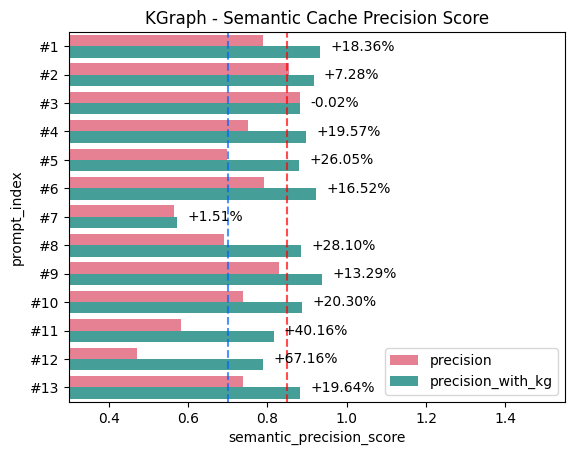

In [7]:
fig, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(x="semantic_precision_score", y="prompt_index", hue="prec", \
            data=data2, palette='husl', orient="h")

for i, m in data.iterrows():
    pct = m.loc['percent_imprv']
    txt = '{:.2f}%'.format(pct) if pct < 0 else '+{:.2f}%'.format(pct)
    
    ax.annotate(text=txt, xy=(m.loc[['precision', 'precision_with_kg']].max(),i),
                xytext=(10, 0), textcoords='offset pixels', ha='left', va='center')

labels = ["#{}".format(i) for i in data2["prompt_index"]]
ax.set_yticklabels(labels)

plt.title("KGraph - Semantic Cache Precision Score")
plt.xlim(.3, 1.55)

low_thresh, high_thresh = .70, .85
colors = ["xkcd:bright blue", "red"]
for color, t in zip(colors, [low_thresh, high_thresh]):
    plt.axvline(x=t, linestyle="--", c=color, alpha=.7)

plt.legend(loc='lower right')
plt.savefig("results/precision.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# from transformers import BertTokenizer, BertModel, GPT2TokenizerFast, GPT2Model

# def get_embedding(text : str, model, tokenizer, *args, **kwargs) -> Tensor:
#     encoded_inp = tokenizer(text, return_tensors="pt", padding="max_length", max_length=64, truncation=True)
#     output_emb = model(**encoded_inp)
#     return output_emb.last_hidden_state

# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
# bert_model = BertModel.from_pretrained("bert-base-cased")

# gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
# gpt2_model = GPT2Model.from_pretrained("openai-community/gpt2")